# Analyse en utilisant different modèles d'embeddings.
- textembedding-gecko@001 (stable)
- textembedding-gecko-multilingual@latest
- multimodalembedding@001

## Setup Project

In [1]:

import vertexai
from google.cloud import bigquery
from tools import *
from bq import save_bq


PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")
client = bigquery.Client(project=PROJECT_ID)
bucket = "ml-demo-384110-bucket"

%load_ext google.cloud.bigquery

## textembedding-gecko@001 (stable)


In [ ]:
%%bigquery

CREATE MODEL immo_us_enriched.llm_embedding_model
REMOTE WITH CONNECTION `ml-demo-384110.connections.genai`
OPTIONS(remote_service_type = 'CLOUD_AI_TEXT_EMBEDDING_MODEL_V1'); 

In [ ]:

%%bigquery

WITH movie_review_embeddings AS (
  SELECT *
  FROM
    ML.EMBED_TEXT(
      MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
      (
        SELECT "Movie 1" AS title, "This movie was fantastic" AS content
        UNION ALL
        SELECT "Movie 2" AS title, "This was the best movie I've ever seen!!" AS content
        UNION ALL
        SELECT "Movie 3" AS title, "This movie was just okay..." AS content
        UNION ALL
        SELECT "Movie 4" AS title, "This movie was terrible." AS content
      ),
      STRUCT(TRUE AS flatten_json_output)
    )
),
average_review_embedding AS (
  SELECT text_embedding
  FROM
    ML.EMBED_TEXT(
      MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
      (SELECT "This movie was average" AS content),
      STRUCT(TRUE AS flatten_json_output)
    )
)
SELECT
  content,
  ML.DISTANCE(
    (SELECT text_embedding FROM average_review_embedding),
    text_embedding,
    'COSINE'
  ) AS distance_to_average_review
FROM
  movie_review_embeddings
ORDER BY distance_to_average_review;

In [ ]:
%%bigquery

SELECT distinct uri, caption_en, caption_fr FROM `ml-demo-384110.immo_us.visual_captioning` 
where caption_en != "" and caption_fr != "" 
limit 3



In [ ]:
%%bigquery


with vc as (
  SELECT distinct uri, caption_en, caption_fr FROM `ml-demo-384110.immo_us.visual_captioning` 
  where caption_en != "" and caption_fr != "" 
  limit 3
)
SELECT *
FROM ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_fr AS content, uri FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
);

In [ ]:
%%bigquery 

with vc as (
  SELECT distinct uri, caption_en, caption_fr FROM `ml-demo-384110.immo_us.visual_captioning` 
  where caption_en != "" and caption_fr != "" 
  limit 3
)
SELECT fr.uri, fr.text_embedding fr_text_embedding, fr.statistics fr_statistics, fr.ml_embed_text_status fr_ml_embed_text_status, fr.caption_fr , 
               en.text_embedding en_text_embedding, en.statistics en_statistics, en.ml_embed_text_status en_ml_embed_text_status, en.caption_en 
FROM ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_fr AS content, uri, caption_fr FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) fr,
ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_en AS content, uri, caption_en FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) en
where en.uri = fr.uri


;

### embedding fr en

In [ ]:
%%bigquery


create or replace table   ml-demo-384110.immo_us_enriched.visual_captioning_embeddings as (

with vc as (
  SELECT distinct uri, caption_en, caption_fr FROM `ml-demo-384110.immo_us.visual_captioning` 
  where caption_en != "" and caption_fr != "" 
  limit 3
)
SELECT fr.uri, fr.text_embedding fr_text_embedding, fr.statistics fr_statistics, fr.ml_embed_text_status fr_ml_embed_text_status, fr.caption_fr , 
               en.text_embedding en_text_embedding, en.statistics en_statistics, en.ml_embed_text_status en_ml_embed_text_status, en.caption_en 
FROM ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_fr AS content, uri, caption_fr FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) fr,
ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_en AS content, uri, caption_en FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) en
where en.uri = fr.uri

)

;



In [ ]:
%%bigquery


select * from   ml-demo-384110.immo_us_enriched.visual_captioning_embeddings


In [ ]:
%%bigquery



SELECT uri,

  fr_text_embedding, en_text_embedding, uri, caption_en, caption_fr, 
  ML.DISTANCE(
    en_text_embedding,
    fr_text_embedding,
    'COSINE'
  ) AS distance_to_average_review
FROM ml-demo-384110.immo_us_enriched.visual_captioning_embeddings

ORDER BY distance_to_average_review; 


### Use translation

In [107]:
%%bigquery


create or replace table   ml-demo-384110.immo_us_enriched.visual_captioning_translated_embeddings as (

with vc as (
  SELECT distinct uri, caption_en,caption_fr_translated_en, caption_fr 
  FROM `ml-demo-384110.immo_us_enriched.visual_captioning_translated` 
  where caption_en != "" and caption_fr != "" 
)
SELECT  fr.uri, 
fr.text_embedding fr_text_embedding, caption_fr_translated_en, fr.statistics fr_statistics, fr.ml_embed_text_status fr_ml_embed_text_status, fr.caption_fr , 
               en.text_embedding en_text_embedding, en.statistics en_statistics, en.ml_embed_text_status en_ml_embed_text_status, en.caption_en 

FROM 
ML.GENERATE_TEXT_EMBEDDING(  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,  (    SELECT caption_fr_translated_en AS content, uri,  caption_fr, caption_en, caption_fr_translated_en FROM vc  ),  STRUCT(TRUE AS flatten_json_output)) 
  fr,
ML.GENERATE_TEXT_EMBEDDING(  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,  (    SELECT caption_en AS content,  caption_en, uri FROM vc      ),  STRUCT(TRUE AS flatten_json_output)) 
  en
where en.uri = fr.uri

)


;



Query is running:   0%|          |

""


In [130]:
%%bigquery

with vc as (
  SELECT distinct uri, caption_en, caption_fr , caption_fr_translated_en
    FROM `ml-demo-384110.immo_us_enriched.visual_captioning_translated` 
  where caption_en != "" and caption_fr != "" 
#  limit 200
)
select count(*) from vc

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,600


## Create table with embeddings

In [108]:
%%bigquery


create or replace table   ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings2 as (

with vc as (
  SELECT distinct uri, caption_en, caption_fr , caption_fr_translated_en
    FROM `ml-demo-384110.immo_us_enriched.visual_captioning_translated` 
  where caption_en != "" and caption_fr != "" 
#  limit 200
)
SELECT fr.uri, fr.text_embedding fr_text_embedding, fr.statistics fr_statistics, fr.ml_embed_text_status fr_ml_embed_text_status, fr.caption_fr , 
               en.text_embedding en_text_embedding, en.statistics en_statistics, en.ml_embed_text_status en_ml_embed_text_status, en.caption_en ,
               tr.text_embedding tr_text_embedding, tr.statistics tr_statistics, tr.ml_embed_text_status tr_ml_embed_text_status, tr.content caption_fr_translated_en ,
FROM ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_fr AS content, uri, caption_fr FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) fr,
ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_en AS content, uri, caption_en FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) en,
ML.GENERATE_TEXT_EMBEDDING(
  MODEL `ml-demo-384110.immo_us_enriched.bqml-gecko`,
  (
    SELECT caption_fr_translated_en AS content, uri, caption_en FROM vc
  ),
  STRUCT(TRUE AS flatten_json_output)
) tr
where en.uri = fr.uri and en.uri = tr.uri 

)




Query is running:   0%|          |

""


### Analyse results

In [136]:
%%bigquery df

create or replace table   ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings_deduplicate as (

SELECT k.*
FROM (
  SELECT concat(uri, caption_fr, caption_en, caption_fr_translated_en) id, ARRAY_AGG(x LIMIT 1)[OFFSET(0)] k 
  FROM `ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings2` x 
  GROUP BY id
)
)


Query is running:   0%|          |

In [137]:
%%bigquery df

select  uri, caption_fr, caption_en, caption_fr_translated_en from ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings_deduplicate 

Query is running:   0%|          |

Downloading:   0%|          |

In [138]:
df.describe()


,uri,caption_fr,caption_en,caption_fr_translated_en
count,624,624,624,624
unique,575,544,557,544
top,gs://ml-demo-384110-bucket/dataset/immo/images/_210591_383642462_photos_3.jpg,une salle de bain avec deux lavabos et un miroir avec l' inscription immobilier.com,the word hosman that is on a picture,a kitchen with white cabinets and a stainless steel oven
freq,8,4,6,4


### Create distance from embeddings

In [139]:
%%bigquery

create or replace table   ml-demo-384110.immo_us_enriched.vc_tr_distance4 as (
  
  
SELECT
  #fr_text_embedding, en_text_embedding, 
   caption_en, caption_fr_translated_en, caption_fr, uri,
  ML.DISTANCE(
    en_text_embedding,
    fr_text_embedding,
    'COSINE'
  ) AS distance_to_en_fr,
  ML.DISTANCE(
    en_text_embedding,
    tr_text_embedding ,
    'COSINE'
  ) AS distance_to_fr_tr_en
from ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings_deduplicate

ORDER BY distance_to_en_fr, distance_to_fr_tr_en
)
;  


Query is running:   0%|          |

""


In [149]:
%%bigquery df
 #df_tr

select  * from    ml-demo-384110.immo_us_enriched.vc_tr_distance4 #where distance_to_fr_tr_en >0.4 #limit 3

#and

# uri= 'gs://ml-demo-384110-bucket/dataset/immo/images/_133675_383410499_photos_4.jpg'




Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_z.set_index('caption_en', inplace=True)

pd.set_option('display.max_colwidth', None)

df_z


In [153]:
df.describe()

,distance_to_en_fr,distance_to_fr_tr_en
count,624.000000,6.240000e+02
mean,0.226656,1.634740e-01
std,0.070206,8.794358e-02
min,0.027970,-2.220446e-16
25%,0.172601,9.983387e-02
50%,0.224875,1.568810e-01
75%,0.278582,2.175716e-01
max,0.441857,4.770395e-01


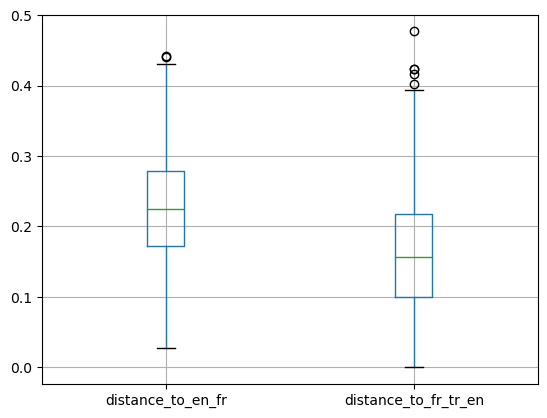

In [152]:
import matplotlib.pyplot as plt

df.boxplot( 
     #rot=90, 
     fontsize=10)
plt.show()

### Create cluster and evaluate centroids 
- TODO

In [ ]:
%%bigquery
#select * from    ml-demo-384110.immo_us_enriched.vc_tr_distance where distance_to_fr_tr_en =0

CREATE OR REPLACE MODEL `ml-demo-384110.immo_us_enriched.vc_clustering`
OPTIONS (
  model_type = 'KMEANS',
  KMEANS_INIT_METHOD = 'KMEANS++',
  num_clusters = 10) AS (
    SELECT
      en_text_embedding #, fr_text_embedding
    
from `ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings`
);

## multimodalembedding@001

- multimodal embeddings
- google.api_core.exceptions.ResourceExhausted: 429 Quota exceeded for
aiplatform.googleapis.com/online_prediction_requests_per_base_model with base
model: multimodalembedding. Please submit a quota increase request.

In [ ]:
%%bash
mkdir multimodalembedding
cd $_
gsutil cp gs://vertex-ai/generative-ai/vision/multimodalembedding/* .
pip3 install -r requirements.txt


In [ ]:
%pip install Polars==0.13.42

In [ ]:
%%bash

pip3 install ratelimit google-cloud-bigquery-storage pyarrow IProgress ipywidgets db-dtypes

In [110]:
# Copyright 2023 Google LLC.
# SPDX-License-Identifier: Apache-2.0
from absl import app
from absl import flags
import base64
# Need to do pip install google-cloud-aiplatform for the following two imports.
# Also run: gcloud auth application-default login.
from google.cloud import aiplatform
from google.protobuf import struct_pb2
import sys
import time
import typing



# Inspired from https://stackoverflow.com/questions/34269772/type-hints-in-namedtuple.
class EmbeddingResponse(typing.NamedTuple):
  text_embedding: typing.Sequence[float]
  image_embedding: typing.Sequence[float]


class EmbeddingPredictionClient:
  """Wrapper around Prediction Service Client."""
  def __init__(self, project : str,
    location : str = "us-central1",
    api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
    client_options = {"api_endpoint": api_regional_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)  
    self.location = location
    self.project = project

  def get_embedding(self, text : str = None, image_bytes : bytes = None):
    if not text and not image_bytes:
      raise ValueError('At least one of text or image_bytes must be specified.')

    instance = struct_pb2.Struct()
    if text:
      instance.fields['text'].string_value = text

    if image_bytes:
      encoded_content = base64.b64encode(image_bytes).decode("utf-8")
      image_struct = instance.fields['image'].struct_value
      image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

    instances = [instance]
    endpoint = (f"projects/{self.project}/locations/{self.location}"
      "/publishers/google/models/multimodalembedding@001")
    response = self.client.predict(endpoint=endpoint, instances=instances)

    text_embedding = None
    if text:    
      text_emb_value = response.predictions[0]['textEmbedding']
      text_embedding = [v for v in text_emb_value]

    image_embedding = None
    if image_bytes:    
      image_emb_value = response.predictions[0]['imageEmbedding']
      image_embedding = [v for v in image_emb_value]

    return EmbeddingResponse(
      text_embedding=text_embedding,
      image_embedding=image_embedding)
        



In [111]:



import os
import requests

def download_image(url):
    """Downloads an image from the specified URL."""

    # Send a get request to the url
    response = requests.get(url)

    print(response)
    # If the request is successful
    if response.status_code == 200:

        # Define image related variables
        image_path = os.path.basename(url)
        image_bytes = response.content
        image_type = response.headers['Content-Type'].split('/')[1]

        # Check for image type, currently only PNG or JPEG format are supported
        if image_type in ("png", "jpg", "jpeg"):
            return image_bytes
            # Write image data to a file
            with open(image_path, "wb") as f:
                f.write(image_bytes)
            return image_path
        else:
            raise Exception("Image can only be in PNG or JPEG format")

    else:
        raise Exception(f"Failed to download image from {url}")
# Download an image
url = "https://storage.googleapis.com/gweb-cloudblog-publish/images/GettyImages-871168786.max-2600x2600.jpg"
#image_path = download_image(url)



user_image = download_image(url)
# Load the newly downloaded image
#user_image = Image.load_from_file(image_path)
#user_image.show()



<Response [200]>


In [7]:
from grpc import RpcError
from ratelimit import limits, sleep_and_retry

import time

from tools import *

# client can be reused.
visual_captioning_multimodalembedding_client = EmbeddingPredictionClient(project= PROJECT_ID)
visual_captioning_multimodalembedding_max_retry = 3

@sleep_and_retry
@limits(calls=120, period=60, raise_on_limit=False)
def visual_captioning_multimodalembedding(image_file_contents = None, text = None):
  global visual_captioning_multimodalembedding_client
  retry = 0
  while(retry < visual_captioning_multimodalembedding_max_retry):
    retry = retry+1
    try:
      start = time.time()
      response = visual_captioning_multimodalembedding_client.get_embedding( image_bytes=image_file_contents, text=text)
      end = time.time()

      #print(response)
      print('Time taken: ', end - start)
      if image_file_contents:
        #print(f"return images {len(response.image_embedding)}")
        return response.image_embedding
      if text:
        #print(f"return text: {len(response.text_embedding)}")
        return response.text_embedding    
    
    except RpcError  as rpc_e:        
        print('RpcError Failed get_embedding: '+ str(rpc_e))
        visual_captioning_multimodalembedding_client = EmbeddingPredictionClient(project= PROJECT_ID)
        print(f"retry: {retry} / {visual_captioning_multimodalembedding_max_retry}")
    except Exception as e: 
        print('Failed to get_embedding: '+ str(e))        
        retry = retry+visual_captioning_multimodalembedding_max_retry

    

#visual_captioning_multimodalembedding(user_image)

NameError: name 'EmbeddingPredictionClient' is not defined

In [8]:
# @title Setup
from google.cloud import bigquery


project = 'ml-demo-384110' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)


In [114]:
def add_vc_multimodalembedding(df, bucket_name = "ml-demo-384110-bucket"):
    #print(f'{name} : {prompt} ')
    #try:
        df[f'multi_embeddings_image'] = df.uri.map(
            lambda uri_name:
                visual_captioning_multimodalembedding(
                    read_bytes_from_gcs(
                        bucket,
                        uri_name.replace(
                            f"gs://{bucket_name}/", "")
                    )
                )
        )
        

        df[f'multi_embeddings_text_en'] = df.caption_en.map(
            lambda text:
                visual_captioning_multimodalembedding(text=text)
        )

        df[f'multi_embeddings_text_fr'] = df.caption_fr.map(
            lambda text:
                visual_captioning_multimodalembedding(text=text)
        )

        df[f'multi_embeddings_text_fr_tr'] = df.caption_fr_translated_en.map(
            lambda text:
                visual_captioning_multimodalembedding(text=text)

        )


    #except:
    #    print("An exception occurred")
        return df



In [115]:
def save_df_bq(df, table_id, truncate = False):
    job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[

bigquery.SchemaField("uri", "STRING")	,
bigquery.SchemaField("fr_text_embedding", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),
bigquery.SchemaField("fr_statistics","STRING", mode="NULLABLE"),	
bigquery.SchemaField("fr_ml_embed_text_status",  "STRING", mode="NULLABLE"),			
bigquery.SchemaField("caption_fr", "STRING", mode="NULLABLE"),		
bigquery.SchemaField("en_text_embedding", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("en_statistics","STRING", mode="NULLABLE"),				
bigquery.SchemaField("en_ml_embed_text_status", "STRING", mode="NULLABLE"),			
bigquery.SchemaField("caption_en", "STRING", mode="NULLABLE"),			
bigquery.SchemaField("tr_text_embedding", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("tr_statistics","STRING", mode="NULLABLE"),			
bigquery.SchemaField("tr_ml_embed_text_status", "STRING", mode="NULLABLE"),			
bigquery.SchemaField("caption_fr_translated_en", "STRING", mode="NULLABLE"),	

bigquery.SchemaField("multi_embeddings_image", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("multi_embeddings_text_en", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("multi_embeddings_text_fr", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("multi_embeddings_text_fr_tr", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			


    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    #write_disposition="WRITE_TRUNCATE",
    
    )
    if truncate:
        print('truncate table: ' + table_id)
        job_config.write_disposition="WRITE_TRUNCATE"

    job = client.load_table_from_dataframe(
        df, table_id, job_config=job_config
    )  # Make an API request.
    job.result()  # Wait for the job to complete.


BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'vqa_embeddings_multimodal3'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME

#save_df_bq(df, project_table)

In [178]:
from bq import save_bq



BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'vqa_embeddings_multimodal_deduplicate'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME

i = 0
finish = False
while (finish == False):
    query = """
    select * from 
    `ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings_deduplicate` 
    """
    if i == 100000:
        query = query + """ limit 1 """
        print(query)
    else:
        query = query + f"""  where concat(uri, caption_en, caption_fr, caption_fr_translated_en) not in (select concat(uri, caption_en, caption_fr, caption_fr_translated_en) from `{project_table}` ) limit 10 """    
        print(query)
        

    query_job = client.query(query)
    if query_job.result().total_rows > 0:
        df = query_job.to_dataframe()
        print( f"Run {i} {len(df.uri)}" ) 
        
#        if len(df.uri) == 0:

#            finish = True
 #       else:
        df = add_vc_multimodalembedding(df)
        print("save_bq")

        save_df_bq(df, table_id=project_table) #, truncate=(i == 0))                
        
        i = i + 1
    else:
        finish = True




    select * from 
    `ml-demo-384110.immo_us_enriched.visual_captioning_tr_embeddings_deduplicate` 
      where concat(uri, caption_en, caption_fr, caption_fr_translated_en) not in (select concat(uri, caption_en, caption_fr, caption_fr_translated_en) from `ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate` ) limit 10 


In [179]:
%%bigquery

create or replace table   ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate2 as (

SELECT k.*
FROM (
  SELECT concat(uri, caption_fr, caption_en, caption_fr_translated_en) id, ARRAY_AGG(x LIMIT 1)[OFFSET(0)] k 
  FROM `ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate` x 
  GROUP BY id
)
)


Query is running:   0%|          |

""


In [180]:
%%bigquery

create or replace table   ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_distance3 as (


SELECT uri,
  #fr_text_embedding, en_text_embedding, 
   caption_en, caption_fr_translated_en, caption_fr, 
  ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_en,    'COSINE'  ) AS distance_to_image_en,
  ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_image_fr,
  ML.DISTANCE(    multi_embeddings_text_en,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_en_fr,
  ML.DISTANCE(    multi_embeddings_text_en,    multi_embeddings_text_fr_tr ,    'COSINE'  ) AS distance_to_en_tr
from ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate2
where ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_fr)
and ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_en)

#ORDER BY distance_to_image_en, distance_to_image_fr, distance_to_en_fr



)
;  

Query is running:   0%|          |

""


In [183]:
%%bigquery df
select     ARRAY_LENGTH(multi_embeddings_image) emb_len_image , 
  ARRAY_LENGTH(multi_embeddings_text_en)  emb_len_en,
  ARRAY_LENGTH(multi_embeddings_text_fr)  emb_len_fr
 from ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate2 


Query is running:   0%|          |

Downloading:   0%|          |

In [184]:
df.describe()

,emb_len_image,emb_len_en,emb_len_fr
count,624.0,624.0,624.0
mean,1408.0,1408.0,1408.0
std,0.0,0.0,0.0
min,1408.0,1408.0,1408.0
25%,1408.0,1408.0,1408.0
50%,1408.0,1408.0,1408.0
75%,1408.0,1408.0,1408.0
max,1408.0,1408.0,1408.0


In [163]:
%%bigquery

#delete

select *
 from immo_us_enriched.vqa_embeddings_multimodal_deduplicate 
 
 where 
    ARRAY_LENGTH(multi_embeddings_image) = 0 
or  ARRAY_LENGTH(multi_embeddings_text_en) = 0 
or  ARRAY_LENGTH(multi_embeddings_text_fr) = 0 

Query is running:   0%|          |

Downloading: |          |

,uri,fr_text_embedding,fr_statistics,fr_ml_embed_text_status,caption_fr,en_text_embedding,en_statistics,en_ml_embed_text_status,caption_en,tr_text_embedding,tr_statistics,tr_ml_embed_text_status,caption_fr_translated_en,multi_embeddings_image,multi_embeddings_text_en,multi_embeddings_text_fr,multi_embeddings_text_fr_tr


In [185]:
%%bigquery df


select * from   ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_distance2

Query is running:   0%|          |

Downloading:   0%|          |

In [186]:
df.describe()

,distance_to_image_en,distance_to_image_fr,distance_to_en_fr,distance_to_en_tr
count,611.000000,611.000000,611.000000,611.000000
mean,0.840589,0.844115,0.495309,0.387965
std,0.062280,0.039985,0.127839,0.172383
min,0.681263,0.713447,0.148175,0.000000
25%,0.795840,0.817786,0.414910,0.272291
50%,0.839233,0.843364,0.502646,0.398828
75%,0.888870,0.873144,0.583320,0.519815
max,0.998091,0.954698,0.818130,0.769610


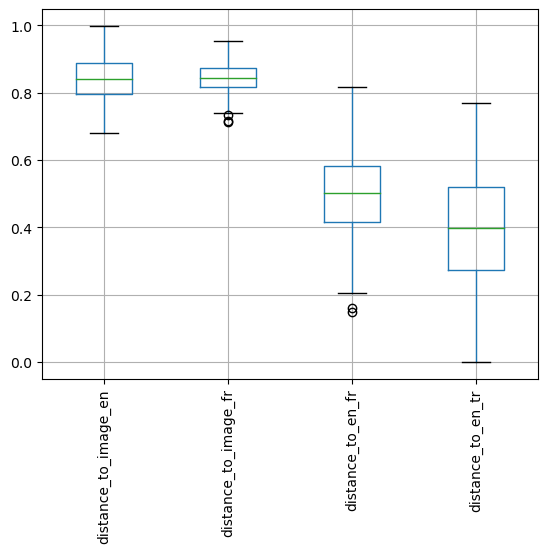

In [187]:
import matplotlib.pyplot as plt

df.boxplot(  rot=90, fontsize=10)
plt.show()


#### Centroid

In [74]:
%%bigquery
#select * from    ml-demo-384110.immo_us_enriched.vc_tr_distance where distance_to_fr_tr_en =0



CREATE OR REPLACE MODEL `ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_cluster`
OPTIONS (
  model_type = 'KMEANS',
  KMEANS_INIT_METHOD = 'KMEANS++',
  num_clusters = 10) AS (
    SELECT
      multi_embeddings_image #, fr_text_embedding
    
from `ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_deduplicate`
);

Query is running:   0%|          |

""


In [ ]:
select *
 from immo_us_enriched.vqa_embeddings_multimodal_deduplicate 
 
 where 
    ARRAY_LENGTH(multi_embeddings_image) = 0 
or  ARRAY_LENGTH(multi_embeddings_text_en) = 0 
or  ARRAY_LENGTH(multi_embeddings_text_fr) = 0 

In [ ]:
import matplotlib.pyplot as plt

df.boxplot(  rot=90, fontsize=10)
plt.show()

In [9]:
from bq import save_bq



BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'vqa_embeddings_multimodal'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME


#df_vqa = add_images_caption_to_df(df)
save_bq(df, table_id=project_table, project_id=PROJECT_ID)

In [ ]:
bucket_name = "ml-demo-384110-bucket"

df[f'multi_embeddings_image'] = df.uri.map(
    lambda uri_name:
        visual_captioning_multimodalembedding(
            read_bytes_from_gcs(
                bucket,
                uri_name.replace(
                    f"gs://{bucket_name}/", "")
            )
        )
)


In [ ]:


df[f'multi_embeddings_text_en'] = df.caption_en.map(
    lambda text:
        visual_captioning_multimodalembedding(text=text)
)

df[f'multi_embeddings_text_fr'] = df.caption_fr.map(
    lambda text:
        visual_captioning_multimodalembedding(text=text)
)

df[f'multi_embeddings_text_fr_tr'] = df.caption_fr_translated_en.map(
    lambda text:
        visual_captioning_multimodalembedding(text=text)

)


In [10]:
from bq import save_bq


BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'vc_embeddings_multimodal'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME


save_bq(df, table_id=project_table, project_id=PROJECT_ID)



save_bq


100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]


In [61]:
%%bigquery df_arr


SELECT
  #fr_text_embedding, en_text_embedding, 
   caption_en, caption_fr_translated_en, caption_fr, ARRAY_LENGTH(multi_embeddings_image) arr_img, ARRAY_LENGTH(multi_embeddings_text_fr) arr_fr, ARRAY_LENGTH(multi_embeddings_text_en) arr_en
  #ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_en,    'COSINE'  ) AS distance_to_image_en,
  #ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_image_fr,
  #ML.DISTANCE(    multi_embeddings_text_en,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_en_fr
from ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal
#where ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_fr)
#and ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_en)
#where ARRAY_LENGTH(multi_embeddings_image) != 1408 

#ORDER BY distance_to_image_en, distance_to_image_fr, distance_to_en_fr



Query is running:   0%|          |

Downloading:   0%|          |

In [62]:
df_arr.describe()

,arr_img,arr_fr,arr_en
count,645.0,645.0,645.0
mean,1403.634109,1408.0,1408.0
std,78.343027,0.0,0.0
min,0.0,1408.0,1408.0
25%,1408.0,1408.0,1408.0
50%,1408.0,1408.0,1408.0
75%,1408.0,1408.0,1408.0
max,1408.0,1408.0,1408.0


In [ ]:
t = "ne maison avec le numéro 50 est à vendre"
visual_captioning_multimodalembedding(text=t)

#df.caption_fr.map(            lambda text:                visual_captioning_multimodalembedding(text=text)        )

In [14]:
df.to_csv("em.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv("em.csv")
df
#.to_csv("em.csv", index=False)

## textembedding-gecko-multilingual@latest


In [4]:

import vertexai
from google.cloud import bigquery
from tools import *


PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")
client = bigquery.Client(project=PROJECT_ID)

%load_ext google.cloud.bigquery

In [ ]:
%pip install google-cloud-aiplatform[pipelines]==1.31.0 google-auth==2.17.3

In [44]:
%%bigquery df


SELECT
  #fr_text_embedding, en_text_embedding, 
  uri,
   caption_en, caption_fr_translated_en, caption_fr
  #ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_en,    'COSINE'  ) AS distance_to_image_en,
  #ML.DISTANCE(    multi_embeddings_image,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_image_fr,
  #ML.DISTANCE(    multi_embeddings_text_en,    multi_embeddings_text_fr ,    'COSINE'  ) AS distance_to_en_fr
from ml-demo-384110.immo_us_enriched.vqa_embeddings_multimodal_distance2
#where ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_fr)
#and ARRAY_LENGTH(multi_embeddings_image) = ARRAY_LENGTH(multi_embeddings_text_en)
#where ARRAY_LENGTH(multi_embeddings_image) != 1408 

#ORDER BY distance_to_image_en, distance_to_image_fr, distance_to_en_fr


Query is running:   0%|          |

Downloading:   0%|          |

In [49]:

from vertexai.language_models import TextEmbeddingModel


from grpc import RpcError
from ratelimit import limits, sleep_and_retry

from tools import *
import time
# client can be reused.

model_multilingual = TextEmbeddingModel.from_pretrained("textembedding-gecko-multilingual@latest")

visual_captioning_multilingual_max_retry = 3

#@sleep_and_retry
#@limits(calls=1000, period=60, raise_on_limit=False)
def visual_captioning_multilingual(text ):
  global model_multilingual
  retry = 0
  while(retry < visual_captioning_multilingual_max_retry):
    retry = retry+1
    try:
      start = time.time()

      embeddings = model_multilingual.get_embeddings([text])
      
      end = time.time()
      
      #print('Time taken: ', end - start)
      if len(embeddings) == 0:
         print("ERROR, no embeddings returned")         
      if len(embeddings) == 1:
        return embeddings[0].values    
      if len(embeddings) > 1:
         print("WARNING, more than one embeddings returned")         
         return embeddings[0].values   
         
    
    except RpcError  as rpc_e:        
        print('RpcError Failed get_embedding: '+ str(rpc_e))
        model_multilingual = TextEmbeddingModel.from_pretrained("textembedding-gecko-multilingual@latest")

        print(f"retry: {retry} / {visual_captioning_multilingual_max_retry}")
    except Exception as e: 
        print('Failed to get_embedding: '+ str(e))        
        retry = retry+visual_captioning_multilingual_max_retry
    
    print(f"retry [{retry}]")
    

def add_vc_multilingual(df, bucket_name = "ml-demo-384110-bucket"):
    #print(f'{name} : {prompt} ')
    #try:

        
        print("en")

        df[f'multilingual_embeddings_text_en'] = df.caption_en.map(            lambda text:                visual_captioning_multilingual(text=text)        )

        print("fr")
        df[f'multilingual_embeddings_text_fr'] = df.caption_fr.map(            lambda text:                visual_captioning_multilingual(text=text)        )

        print("tr")
        df[f'multilingual_embeddings_text_fr_tr'] = df.caption_fr_translated_en.map(            lambda text:                visual_captioning_multilingual(text=text)        )


    #except:
    #    print("An exception occurred")
        return df


df = add_vc_multilingual(df)
df.describe()

en
fr
tr


,uri,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr
count,611,611,611,611,611,611,611
unique,575,557,540,544,557,544,540
top,gs://ml-demo-384110-bucket/dataset/immo/images...,the word hosman that is on a picture,a kitchen with white cabinets and a siemens oven,une cuisine avec des armoires blanches et un f...,"[-0.01636134646832943, -0.02084939368069172, 0...","[-0.01975165493786335, -0.01723782904446125, 0...","[-0.044276997447013855, -0.01569574885070324, ..."
freq,8,6,4,4,6,4,4


In [50]:
df[df['multilingual_embeddings_text_en'] == None] 

,uri,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr


In [51]:
df[df['multilingual_embeddings_text_fr'] == None] 

,uri,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr


In [52]:
df[df['multilingual_embeddings_text_fr_tr'] == None] 

,uri,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr


### Save data in BQ

In [53]:
BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'vqa_embeddings_multilangual'
project_table = PROJECT_ID + "." +BQ_DATASET_NAME +"." + BQ_TABLE_NAME

def save_df_bq_multilangual(df, table_id, truncate = False):
    job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[

bigquery.SchemaField("uri", "STRING")	,
bigquery.SchemaField("caption_en", "STRING"),		
bigquery.SchemaField("caption_fr", "STRING"),		
bigquery.SchemaField("caption_fr_translated_en", "STRING"),	

bigquery.SchemaField("multilingual_embeddings_text_en", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("multilingual_embeddings_text_fr", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			
bigquery.SchemaField("multilingual_embeddings_text_fr_tr", bigquery.enums.SqlTypeNames.FLOAT, mode="REPEATED"),			


    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    #write_disposition="WRITE_TRUNCATE",
    
    )
    if truncate:
        print('truncate table: ' + table_id)
        job_config.write_disposition="WRITE_TRUNCATE"

    job = client.load_table_from_dataframe(
        df, table_id, job_config=job_config
    )  # Make an API request.
    job.result()  # Wait for the job to complete.

save_df_bq_multilangual(df, project_table, True)

truncate table: ml-demo-384110.immo_us_enriched.vqa_embeddings_multilangual


In [64]:
%%bigquery 


create or replace table   ml-demo-384110.immo_us_enriched.vqa_embeddings_multilangual_distance as (
  
		
  
SELECT
  #fr_text_embedding, en_text_embedding, 
   caption_en, caption_fr_translated_en, caption_fr, uri,
  ML.DISTANCE(
    multilingual_embeddings_text_en,
    multilingual_embeddings_text_fr,
    'COSINE'
  ) AS distance_to_en_fr,
  ML.DISTANCE(
    multilingual_embeddings_text_en,
    multilingual_embeddings_text_fr_tr ,
    'COSINE'
  ) AS distance_to_fr_tr_en,
  ML.DISTANCE(
    multilingual_embeddings_text_fr,
    multilingual_embeddings_text_fr_tr ,
    'COSINE'
  ) AS distance_to_fr_tr
from ml-demo-384110.immo_us_enriched.vqa_embeddings_multilangual

ORDER BY distance_to_en_fr, distance_to_fr_tr_en
)
;  


Query is running:   0%|          |

""


In [70]:
%%bigquery df
select * from ml-demo-384110.immo_us_enriched.vqa_embeddings_multilangual_distance


Query is running:   0%|          |

Downloading:   0%|          |

### Analyse results

In [71]:
df.describe()


,distance_to_en_fr,distance_to_fr_tr_en,distance_to_fr_tr
count,611.000000,6.110000e+02,611.000000
mean,0.186962,1.234686e-01,0.116112
std,0.065755,7.805807e-02,0.039811
min,0.030071,-2.220446e-16,0.030906
25%,0.137848,6.225101e-02,0.083707
50%,0.175767,1.128082e-01,0.118265
75%,0.235339,1.803134e-01,0.141462
max,0.440202,4.075310e-01,0.240445


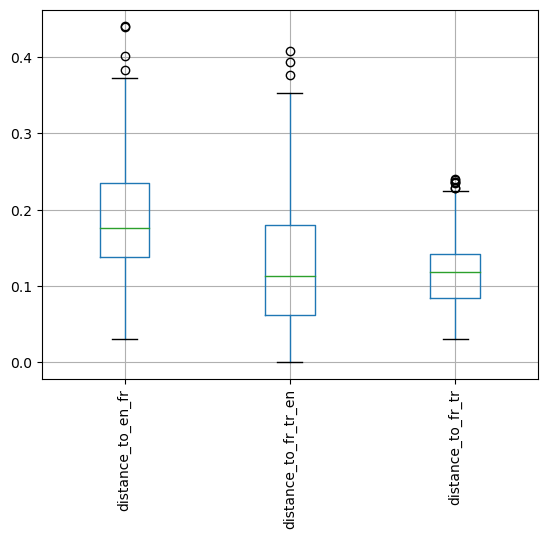

In [72]:
import matplotlib.pyplot as plt

df.boxplot(  rot=90, fontsize=10)
plt.show()

In [58]:
df.describe()


,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr
count,611,611,611
unique,611,611,611
top,"[0.03327054902911186, -0.045789483934640884, 0...","[0.029539287090301514, -0.05211855098605156, 0...","[0.016384905204176903, -0.04228445887565613, 0..."
freq,1,1,1


In [21]:
df.describe()

,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr
count,611,611,611,117,120,0
unique,557,540,544,115,100,0
top,the word hosman that is on a picture,a kitchen with white cabinets and a siemens oven,une cuisine avec des armoires blanches et un f...,"[0.004478777293115854, -0.018535349518060684, ...","[0.029824208468198776, -0.024249466136097908, ...",NaN
freq,6,4,4,2,4,NaN


In [17]:
df.describe()

,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr
count,611,611,611,117,0,0
unique,557,540,544,115,0,0
top,the word hosman that is on a picture,a kitchen with white cabinets and a siemens oven,une cuisine avec des armoires blanches et un f...,"[0.004478777293115854, -0.018535349518060684, ...",NaN,NaN
freq,6,4,4,2,NaN,NaN


In [18]:
df.head()

,caption_en,caption_fr_translated_en,caption_fr,multilingual_embeddings_text_en,multilingual_embeddings_text_fr,multilingual_embeddings_text_fr_tr
0,a floor plan of a house with the word maison o...,a floor plan of the main house,un plan d' étage de la maison principale,"[0.03327054902911186, -0.045789483934640884, 0...",None,None
1,a house with a basketball hoop in front of it,a big house with a tree outside,une grande maison avec un arbre à l' extérieur,"[0.018193695694208145, -0.012516985647380352, ...",None,None
2,a bathroom with a sink and a mirror and the wo...,a picture of a bathroom by hosman,une photo d' une salle de bain par hosman,"[-0.008245068602263927, -0.03270513936877251, ...",None,None
3,a pool table in a room with the word immo on t...,a pool table sits inside an attic,une table de billard est assise à l' intérieur...,"[0.013310061767697334, -0.01480595301836729, 0...",None,None
4,an attic with a pool table and a staircase,a pool table sits inside an attic,une table de billard est assise à l' intérieur...,"[-0.0013521496439352632, -0.021865107119083405...",None,None


## Other embeddings models
 - https://cloud.google.com/bigquery/docs/generate-embedding-with-tensorflow-models#bert_2

In [ ]:
%pip install bigquery-ml-utils

%pip install bigquery-ml-utils

In [ ]:
from bigquery_ml_utils import model_generator

# Establish an instance of TextEmbeddingModelGenerator.
text_embedding_model_generator = model_generator.TextEmbeddingModelGenerator()

# Generate a BERT model.
OUTPUT_MODEL_PATH = "./embeddings/bert/"
text_embedding_model_generator.generate_text_embedding_model('bert', OUTPUT_MODEL_PATH)

In [ ]:
!gsutil cp -r ./embeddings/bert/ gs://BUCKET_PATH/bert_model

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL tf_models_tutorial.bert_model
INPUT(embedding_input STRING)
OUTPUT(embedding ARRAY)
REMOTE WITH CONNECTION `PROJECT_ID.CONNECTION_LOCATION.CONNECTION_NAME`
OPTIONS (
  ENDPOINT = "https://us-central1-aiplatform.googleapis.com/v1/projects/PROJECT_ID/locations/ENDPOINT_LOCATION/endpoints/ENDPOINT_ID");